# Import neccessary libraries

In [12]:
#Libraries

import pandas as pd
import numpy as np
import warnings
import pytz
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

warnings.filterwarnings("ignore")

# Preliminary EDA

We will load the dataset to perform some basic EDA to get a small idea of the data to understand its distribution, patterns and irregularities and outliers. The outliers will the clean and dealt with before we make an attempt to look for patterns and trends


In [7]:
# Load data from csv file into a dataframe

df = pd.read_csv("data_for_exercise.csv")
df.columns = ['ts','solar','wind','cons','market','spot']

In [8]:
# SOME EDA

df.describe()

df['solar'][964:967] = 0
df = df.dropna()

,solar,wind,cons,market,spot
count,2864.000000,2.878000e+03,2878.000000,2878.000000,2878.000000
mean,3886.478003,8.034573e+11,58241.932245,39.886346,74.307085
std,6256.780728,4.310307e+13,10279.364137,19.995454,1863.390702
min,0.000000,0.000000e+00,0.000000,-155.675132,-83.010000
25%,0.000000,8.385305e+03,50294.750000,33.124043,33.555000
50%,4.000000,1.419302e+04,58235.000000,40.809486,41.085000
75%,5988.250000,2.559897e+04,67331.750000,49.264177,49.060000
max,28822.000000,2.312350e+15,75183.000000,151.681478,100000.000000


We see some solar data is missing. In this case we will set a few obvious rows based on time of day to 0. We then omit the rest as we do not want to make many assumptions. Making assumptions can limit the accuracy of the strategy, as the underlying relationships in the data may not be accurate or complete. This can lead to poor performance and high risk.

In [109]:
# Convert the timestamp column to datetime

df['ts'] = pd.to_datetime(df['ts'], infer_datetime_format=True,utc=True)
utc_tz = pytz.timezone("UTC")
df['ts'] = df['ts'].dt.tz_convert(utc_tz)
df['ts'] = df['ts'].dt.strftime('%Y-%m-%d %H')

# Grouping

It is fair to assume that the solar and wind supply as well as consumptioncan vary with season and time of day. Therefore, we group the data based on season and time of day to better spot and deal with outliers. Only one example is shown here.

In [16]:
# Extract the month from the datetime object
df['ts'] = pd.to_datetime(df['ts'])
df['hour'] = df['ts'].dt.hour

def season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
    
def time_of_day(hour):
    if hour in range(6,12):
        return 'morning'
    elif hour in range(12,18):
        return 'afternoon'
    else:
        return 'night'

df['time_of_day'] = df['hour'].apply(time_of_day)
df['season'] = df['ts'].dt.month.apply(season)

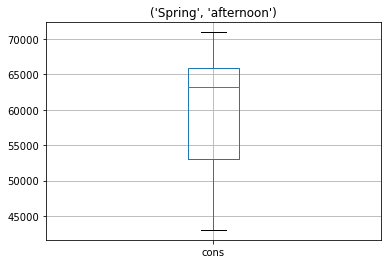

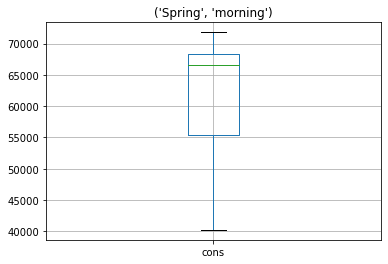

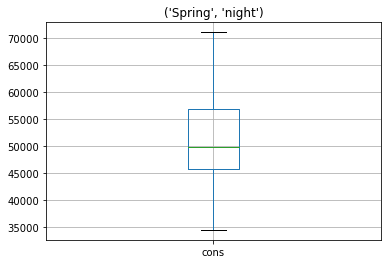

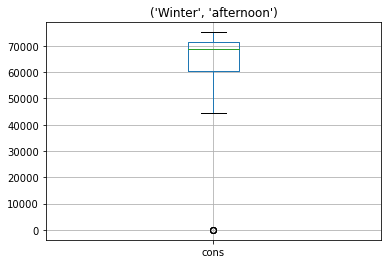

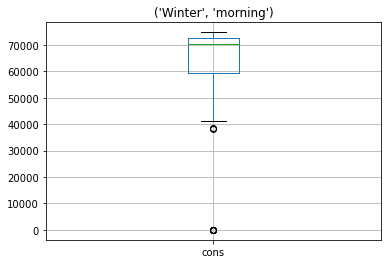

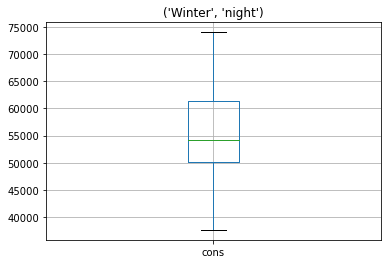

In [25]:
# Group data by season and hour
df['cons']=df['cons'].astype(float)
data_by_season_and_hour = df.groupby(['season','time_of_day'])

# Create box plots for each season and hour
for name, group in data_by_season_and_hour:
    group.boxplot(column='cons')
    plt.title(name)
    plt.show()

# Remove Outliers

In [26]:
# Group by time of day and season to remove outliers
grouped_data = df.groupby(['time_of_day', 'season'])

# Create a new dataframe to store the filtered data
filtered_data = pd.DataFrame(columns=df.columns)

# Iterate over each group and remove outliers
for name, group in grouped_data:
    lower_bound = np.percentile(group['wind'], 1)
    upper_bound = np.percentile(group['wind'], 99)
    group = group[(group['wind'] > lower_bound) & (group['wind'] < upper_bound)]
    filtered_data = pd.concat([filtered_data, group])

df = filtered_data.sort_values(by=['ts'])

In [20]:
# Group by time of day and season
grouped_data = df.groupby(['time_of_day', 'season'])

# Create a new dataframe to store the filtered data
filtered_data = pd.DataFrame(columns=df.columns)

# Iterate over each group and remove outliers
for name, group in grouped_data:
    lower_bound = np.percentile(group['cons'], 1)
    upper_bound = np.percentile(group['cons'], 99)
    group = group[(group['cons'] > lower_bound) & (group['wind'] < upper_bound)]
    filtered_data = pd.concat([filtered_data, group])

df = filtered_data.sort_values(by=['ts'])

,ts,solar,wind,cons,market,spot,hour,time_of_day,season
0,2019-01-01 00:00:00,0.0,22648.2641,41422,11.980883,10.07,0,night,Winter
1,2019-01-01 01:00:00,0.0,24762.6254,40279,5.776289,-4.08,1,night,Winter
2,2019-01-01 02:00:00,0.0,26900.2746,39035,1.898098,-9.91,2,night,Winter
3,2019-01-01 03:00:00,0.0,29211.7893,38871,0.605588,-7.41,3,night,Winter
4,2019-01-01 04:00:00,0.0,30740.5101,38508,-1.794566,-12.55,4,night,Winter
...,...,...,...,...,...,...,...,...,...
2873,2019-04-30 17:00:00,1801.0,7447.4720,61012,50.239146,54.40,17,afternoon,Spring
2874,2019-04-30 18:00:00,304.0,7553.1701,59910,49.589835,51.76,18,night,Spring
2875,2019-04-30 19:00:00,0.0,7120.3044,58277,47.151411,48.71,19,night,Spring
2876,2019-04-30 20:00:00,0.0,7000.1985,54546,43.846923,46.28,20,night,Spring


In [66]:
# Find the index of the row to remove

index_to_remove = df.index[df['spot'] >= 1000]
df = df.drop(index_to_remove)

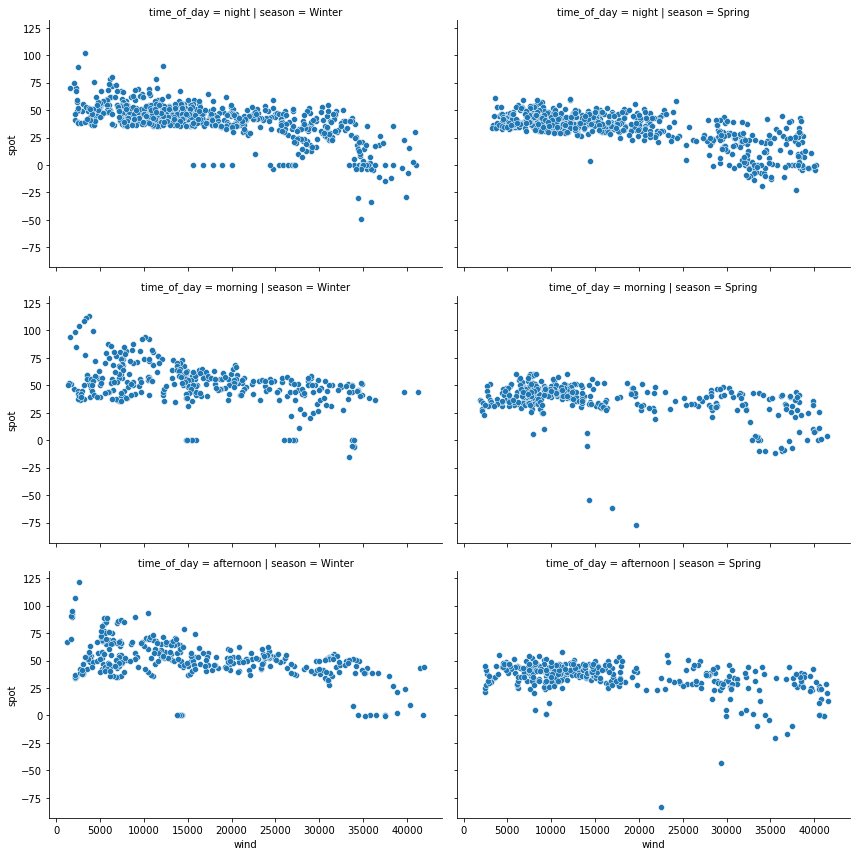

In [67]:
#quick plots to see dependance
g = sns.FacetGrid(df, row='time_of_day', col='season',height=4, aspect=1.5)
g.map(sns.scatterplot,'wind','spot')

# Feature Engineering

Since there is no clear relationship between wind supply and prices, we may have to create new features to find patterns and use as features in the model

In [78]:
# NEW FEATURES


df['total_supply_forecast'] = df['solar'] + df['wind']
df['demand_supply_ratio'] = df['cons']/df['total_supply_forecast']
df['demand_supply_diff'] = df['cons'] - df['total_supply_forecast']
df["demand_supply_diff"] = (df["demand_supply_diff"] - df["demand_supply_diff"].min()) / ( df["demand_supply_diff"].max() -  df["demand_supply_diff"].min())
df['wind_proportion'] = df['wind'] / df['total_supply_forecast']
df['solar_proportion'] = df['solar'] / df['total_supply_forecast']

# relative price of wind
df['wind_price'] = df['spot'] * df['wind_proportion']

# relative price of solar
df['solar_price'] = df['spot'] * df['solar_proportion']


df['wind_price_to_demand'] = df['wind_price'] / (df["cons"])
df['solar_price_to_demand'] = df['solar_price'] / (df["cons"])

# Wind variability 

df['wind_diff'] = df['wind'] - df['wind'].shift(1)
df['solar_diff'] = df['solar'] - df['solar'].shift(1)

# The idea behind using lagged spot price as a feature is that the spot price at a previous time period may have an impact on the current spot price, and therefore can be used as an indicator of future spot price movements.

df['previous_spot'] = df['spot'].shift(1)

# historical market data to compare hour with hour

df['historical_market'] = df['market'].shift(24)

df['timestamp_diff'] = (df['ts'] - df['ts'].shift(24)).dt.total_seconds()/3600

df['is_lagged'] = df['timestamp_diff'] == 24
df = df[df['timestamp_diff'] == 24]
df.drop(columns=['timestamp_diff'], inplace=True)

df['pnl'] = df['market'] - df['spot']



df = df.dropna()

# Some More EDA

Now that we have the important features, we can perform some more analysis to better undertsand how variables are related to each other and how it is related to the target variable

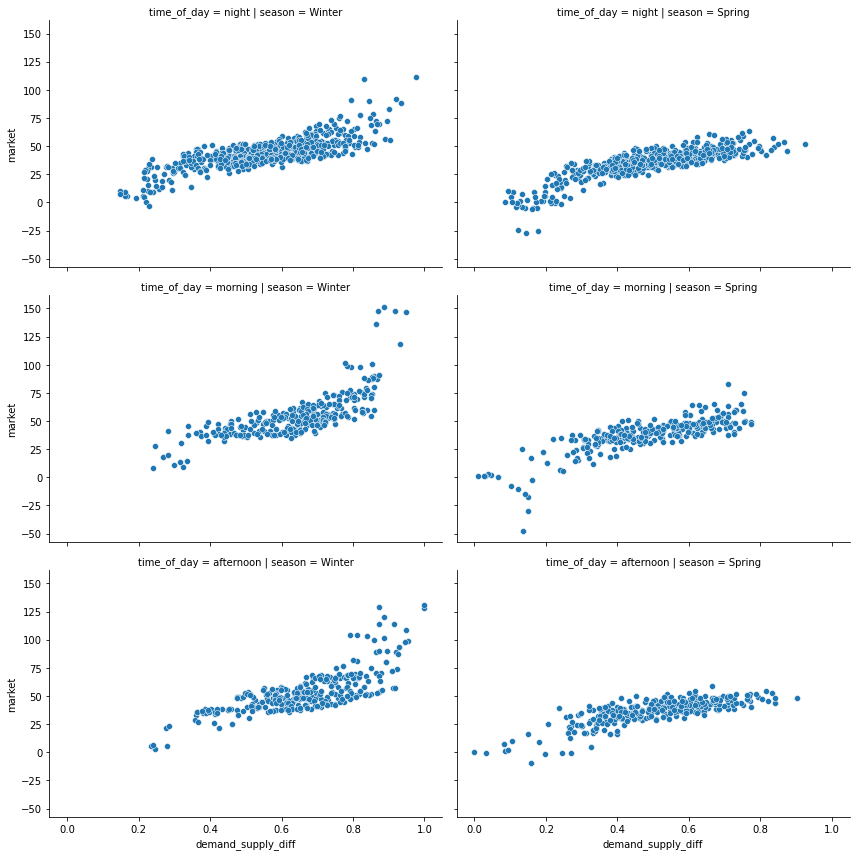

In [82]:
# Create a FacetGrid with 'hour' and 'season' as the row and column variables
g = sns.FacetGrid(df, row='time_of_day', col='season',height=4, aspect=1.5)
g.map(sns.scatterplot,'demand_supply_diff','market')

The graphs above show how the market price increases with the increase in difference between the forecasted demand and supply

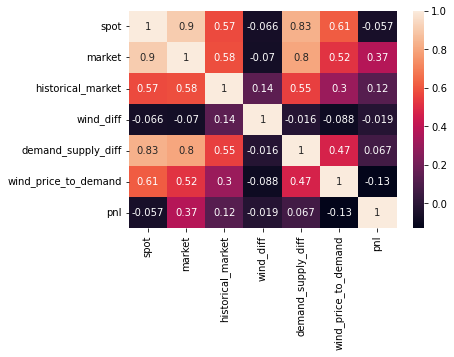

In [87]:
corr = df[['spot','market','historical_market','wind_diff','demand_supply_diff','wind_price_to_demand','pnl']].corr()

# heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.show()

Here we can see the correlations between different variables with each other and the target variable (market and pnl). The lack of correlation between pnl and other features tells us that it may not be the best target variable. 

In [94]:
df.groupby(['time_of_day','season']).mean()

solar          wind          cons     market  \
time_of_day season                                                        
afternoon   Spring   8481.290210  16074.238734  60739.153846  36.111778   
            Winter   3771.003448  14421.320374  66210.089655  53.549493   
morning     Spring  13079.372340  14648.280807  62718.712766  37.895433   
            Winter   5688.319588  14487.310873  66450.281787  54.636330   
night       Spring    152.730973  15765.146178  51395.187611  35.053676   
            Winter      0.000000  15995.658721  56005.151007  44.013831   

                         spot  total_supply_forecast  demand_supply_ratio  \
time_of_day season                                                          
afternoon   Spring  35.998881           24555.528944             3.178147   
            Winter  52.493414           18192.323822             5.083256   
morning     Spring  38.251773           27727.653148             2.591309   
            Winter  53.059416           20175.630460             4.118273   
night       Spring  35.208920           15917.877151             4.442739   
            Winter  42.982131           15995.658721             5.075454   

                    wind_proportion  solar_proportion  wind_price  \
time_of_day season                                                  
afternoon   Spring         0.651113          0.348887   23.911931   
            Winter         0.790417          0.209583   42.296805   
morning     Spring         0.509182          0.490818   19.136121   
            Winter         0.716944          0.283056   38.320277   
night       Spring         0.987651          0.012349   34.642951   
            Winter         1.000000          0.000000   42.982131   

                    solar_price  wind_price_to_demand  solar_price_to_demand  \
time_of_day season                                                             
afternoon   Spring    12.086951              0.000390               0.000203   
            Winter    10.196609              0.000633               0.000158   
morning     Spring    19.115652              0.000301               0.000307   
            Winter    14.739138              0.000576               0.000221   
night       Spring     0.565969              0.000673               0.000010   
            Winter     0.000000              0.000764               0.000000   

                     wind_diff   solar_diff  previous_spot       pnl  \
time_of_day season                                                     
afternoon   Spring   75.037162 -2862.513986      33.781224  0.112897   
            Winter  141.850930 -1632.479310      51.133207  1.056079   
morning     Spring  119.344949  2716.950355      39.844716 -0.356340   
            Winter -121.549081  1650.082474      52.536014  1.576914   
night       Spring -179.832143    73.350442      35.629593 -0.155244   
            Winter   -5.087731    -0.001678      44.097299  1.031700   

                    historical_market  is_lagged  demand_supply_diff  
time_of_day season                                                    
afternoon   Spring          35.543138        1.0            0.500530  
            Winter          53.988255        1.0            0.662940  
morning     Spring          36.291503        1.0            0.484163  
            Winter          54.532108        1.0            0.639018  
night       Spring          34.141015        1.0            0.490837  
            Winter          43.540644        1.0            0.553036

# Build our Model

Initially, looking at the data, it seemed that the best way to build this strategy would be to calculte the pnl and classifiy it as long or short and use a classification algorighm to predict the pnl class. However, from our EDA, we have found the lack of relationship between pnl and our engineered features. Therefore, we wil instead a random forest model to predict market price and place buy and sell signals based on this predicted market price.

Random Forest is a better approach for this model because it is a type of ensemble learning method that combines multiple decision trees to improve the overall performance of the model. It helps to reduce overfitting and increase the accuracy of the model. Additionally, it is robust to the presence of outliers and irrelevant features in the data, which can be particularly useful 

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Split data into training and testing sets

df['time_of_day'] = le.fit_transform(df['time_of_day'])
df['season'] = le.fit_transform(df['season'])

train_df, test_df = train_test_split(df, test_size=0.2)

# Train a Random Forest model on the training data
X_train = train_df[['wind_diff', 'solar_diff', 'demand_supply_diff','spot','historical_market','total_supply_forecast','wind_price_to_demand','season','time_of_day']]
y_train = train_df['market']

model = RandomForestRegressor(n_estimators=500, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the testing data
X_test = test_df[['wind_diff', 'solar_diff', 'demand_supply_diff','spot','historical_market','total_supply_forecast','wind_price_to_demand','season','time_of_day']]
y_test = test_df['market']

y_pred = model.predict(X_test)

# Model's performance
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', mae)

Mean Absolute Error: 3.3855058864611864


# BACKTEST

Now that we have our predictor, let us test how profitable it would be to use this in our trading. This is a simple backtest that does not take into account the tradings costs and slippage (due to volatility).

In [105]:
# create a new column for predicted market price
test_df["predicted_market_price"] = y_pred


profit = 0


for i in range(len(test_df)):
    spot_price = test_df['spot'].iloc[i]
    predicted_market_price = test_df['predicted_market_price'].iloc[i]
    market_price = test_df['market'].iloc[i]
    
    if predicted_market_price > spot_price:
        # open a long position on the spot market
        profit += market_price - spot_price
    
    else:
        # open a short position on the spot market
        profit += spot_price - market_price

print("Total profit: ", profit)

Total profit:  1009.5044870339989


In [114]:
test_df[["predicted_market_price","market","spot"]]

,predicted_market_price,market,spot
1351,54.539963,60.045174,51.88
1030,40.882426,31.224421,41.51
660,52.528855,50.158071,51.36
793,39.040221,38.645441,40.48
1291,46.366151,44.232992,46.99
...,...,...,...
1871,38.172566,38.807425,38.28
115,50.134246,47.224183,52.75
2279,37.969885,41.098133,39.86
1370,37.555146,36.888701,37.99
